# TEXT to SQL: Using ML to generate structured queries from Natural Language

Capstone Project by Alberto Marengo

NOTE: This is Jupyter Notebook 5 of 6 for this project. The modeling part has been split into multiple notebooks because of the long running times. This notebook is almost identical to Notebook 4 because only the class weights are added to the previous model, most of the comments are going to be the same. 

In this notebook we continue to explore the world of Neural Networks offered in the `Keras` library interface into the `Tensorflow` library. 

Because the class imbalance in the input data is affecting the results of the five outputs (confusion matrices showing poor prediction score in less frequent classes) we are going to try to apply weights to the inputs. 

Using the same model as in Notebook 4, we are going to pass these weights when compiling and force the model to give more importance to the less frequent classes.

Because `tensorflow` only allows weight classes on one input we are going to create a customized loss function that will take care of this problem. 

We will see the the loss function implementation into more detail in this notebook.

Let's start loading the libraries!

In [1]:
import json

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import class_weight

import tensorflow
from tensorflow import math
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, LSTM, GRU, BatchNormalization, InputLayer, Bidirectional, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer

## Load the data

We are going to load the data (train, validation and test set) from the `.csv` files we created in notebook 1. 

In [2]:
X_train = pd.read_csv('processed_data/X_train.csv', index_col=0, squeeze=True)
y_train = pd.read_csv('processed_data/y_train.csv', index_col=0, squeeze=True)

X_val = pd.read_csv('processed_data/X_val.csv', index_col=0, squeeze=True)
y_val = pd.read_csv('processed_data/y_val.csv', index_col=0)

X_test = pd.read_csv('processed_data/X_test.csv', index_col=0, squeeze=True)
y_test = pd.read_csv('processed_data/y_test.csv', index_col=0)

NOTE: Setting `squeeze=True` allows to create a Pandas Series when there is only one column (`question`). This options is necessary when tokenizing the data and make sure that all the original rows are preserved.

## Tokenizer

As we did in notebook 2, we are going to user tensorflow's `Tokenizer` on `X_train` to transform the text into word indexes. We are going to use a max number of words of 5,000.

**NOTE**

We are going to set `char_level=False`. That means that we are going to tokenize at 'word' level. We have also tried to tokenize at the 'character' level but the model performance was not better. For reason of time, it was not possible to report a commented notebook for the 'char' level trial in this deliverable.

In [3]:
# Instantiate the tokenizer
tokenizer = Tokenizer(char_level=False, lower=True, num_words=5000) 
# Fit the tokenizer to X_train
tokenizer.fit_on_texts(X_train)

In [4]:
word_to_number = tokenizer.word_index
number_to_word = tokenizer.index_word

all_words = list(word_to_number.keys())

print(f"Total words in file: {len(all_words)}")

Total words in file: 32677


The total number of words in `question` was originally 32,677 but we restricted our vocabulary to 5,000.

Let's see what the rows of X_train look like transformed into word indexes.

In [5]:
# Transform X_train from words to indexes (sequences)
data = tokenizer.texts_to_sequences(X_train)
data

[[101, 99, 2, 1, 333, 43, 8, 205, 510],
 [2, 3, 1, 604, 107, 45, 1, 172, 107, 1726, 13, 240, 133],
 [2, 3, 1, 324, 8, 205, 510],
 [16, 1, 1925, 2848, 8, 1, 907, 714, 1789],
 [17, 20, 219, 3, 1, 1237, 2690, 3],
 [2, 3, 1, 1237, 2690, 45, 1, 1067, 107, 659, 3, 2691, 122],
 [18, 3, 1, 471, 8, 1, 584, 33, 390],
 [17, 20, 219, 3, 1, 199],
 [17, 20, 219, 3, 1, 1067, 107, 659, 3, 3968, 56],
 [2, 3, 1, 200, 2006, 9, 1, 584, 33, 3, 281],
 [2, 121, 1, 1096, 4, 5, 3293],
 [2, 3, 1, 701, 715, 406, 4, 1, 2849, 305, 141],
 [2, 91, 31, 38, 19, 56, 863, 62],
 [2, 91, 31, 1, 38, 22, 11, 935, 13, 605, 62, 177, 1555, 863, 62],
 [2, 91, 31, 1, 38, 22, 11, 935, 13, 605, 62, 127, 177, 923, 60],
 [2, 53, 31, 1, 38, 62, 3969, 89],
 [18, 52, 13, 1, 605, 3593, 62, 483, 680],
 [14, 19, 6, 1425],
 [2, 91, 31, 1425, 89, 8],
 [17, 20, 19, 119, 91, 49],
 [14, 91, 6, 13, 605, 13, 272, 523],
 [14, 91, 31, 1, 38, 22, 52, 228, 432, 936],
 [14, 53, 119, 1926, 89],
 [2, 19, 3, 1, 38, 22, 52, 390, 272],
 [14, 80, 3, 1, 38,

We are now going to look for the row with the greatest number of words (max length). This is going to be our sequence length, one of the required inputs for the Embedding Layer.

In [6]:
seq_length = max([len(ls) for ls in data])

We re going now to make all the tokenized rows the same length (`seq_length` = 47) by padding with `0` the empty spaces.

In [7]:
# Iterate over all the tokenized rows
for row in data:
    # Create list of `0`s of length  seq-length - row length
    app_ls = [0]*(seq_length - len(row))
    # Attach the string of `0`s to the row
    row.extend(app_ls)
        
X_tok = np.array(data)

# Let's look at the shapes
print(X_tok.shape)
print(y_train.shape)

(55932, 47)
(55932, 5)


Now we see what shave the tokenized X is (55,932 x 47). We can also print `X_tok` (the tokenized X_train)

In [8]:
X_tok

array([[ 101,   99,    2, ...,    0,    0,    0],
       [   2,    3,    1, ...,    0,    0,    0],
       [   2,    3,    1, ...,    0,    0,    0],
       ...,
       [   2,  652,    4, ...,    0,    0,    0],
       [   2,    3,    1, ...,    0,    0,    0],
       [  14,  525, 1570, ...,    0,    0,    0]])

Using the same tokenizer that was fitted on the `train` set we are going to transform also the `val` and `test` sets the same way we did above.

In [9]:
# Transform X_val into tokens
data_val = tokenizer.texts_to_sequences(X_val)

Pad the empty spaces with `0`.

In [10]:
# Iterate over all the tokenized rows
for row in data_val:
    if len(row) <= seq_length:
        # Create list of `0`s of length  seq-length - row length
        app_ls = [0]*(seq_length - len(row))
        # Attach the string of `0`s to the row
        row.extend(app_ls)
    else:
        del row[seq_length:]
X_val_tok = np.array(data_val)

# Let's look at the shapes
print(X_val_tok.shape)

(8357, 47)


In [11]:
# Transform X_test into tokens
data_test = tokenizer.texts_to_sequences(X_test)

Pad the empty spaces with `0`.

In [12]:
# Iterate over all the tokenized rows
for row in data_test:
    if len(row) <= seq_length:
        # Create list of `0`s of length  seq-length - row length
        app_ls = [0]*(seq_length - len(row))
        # Attach the string of `0`s to the row
        row.extend(app_ls)
    else:
        del row[seq_length:]
X_test_tok = np.array(data_test)

# Let's look at the shapes
print(X_test_tok.shape)

(15747, 47)


We are also going to save into variables the number of unique values in each target. This five numbers will be the dimensions of each output.

In [13]:
out_classes_sel = y_train.iloc[:, 0].nunique()
out_classes_agg = y_train.iloc[:, 1].nunique()
out_classes_w0 = y_train.iloc[:, 2].nunique()
out_classes_w1 = y_train.iloc[:, 3].nunique()
out_classes_w2 = y_train.iloc[:, 4].nunique()

At this point we are going to use `sklearn` [compute_class_weight](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) to calculate the weights of the classes in the five outputs.

The purpose of calculating class weights is to give more importance to less frequent classes.

In [14]:
cl_weights_sel = class_weight.compute_class_weight('balanced', np.unique(y_train.iloc[:, 0]), y_train.iloc[:, 0])
cl_weights_agg = class_weight.compute_class_weight('balanced', np.unique(y_train.iloc[:, 1]), y_train.iloc[:, 1])
cl_weights_w0 = class_weight.compute_class_weight('balanced', np.unique(y_train.iloc[:, 2]), y_train.iloc[:, 2])
cl_weights_w1 = class_weight.compute_class_weight('balanced', np.unique(y_train.iloc[:, 3]), y_train.iloc[:, 3])
cl_weights_w2 = class_weight.compute_class_weight('balanced', np.unique(y_train.iloc[:, 4]), y_train.iloc[:, 4])

/home/ec2-user/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7 8 9], y=0        5
1        4
2        2
3        1
4        3
        ..
55927    1
55928    4
55929    2
55930    5
55931    5
Name: select_col, Length: 55932, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/ec2-user/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5], y=0        0
1        0
2        0
3        0
4        3
        ..
55927    0
55928    0
55929    0
55930    3
55931    0
Name: agg_col, Length: 55932, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/ec2-u

We got a `FutureWarning` message that can be ignored as it does not halt the execution of the program. It looks like it's a sklear version issue.

For more information on `FutureWarning` this [link](https://machinelearningmastery.com/how-to-fix-futurewarning-messages-in-scikit-learn/) can be useful.

## Recurring Neural Network

Below is a sketch of the multi-output model we built in the previous notebook.



<img src='figures/RNN.jpg' width=1000 height=1000/>


First, let's set up a random seed in order to have the same result every time we run it.

In [15]:
np.random.seed(1)
tensorflow.random.set_seed(2)

Let's save the vocabulary size in a variable. We chose this number to be 5,000 when we instantiated the tokenizer.

In [16]:
vocab_size = len(tokenizer.texts_to_matrix(X_train)[0])

Below is the class responsible for creating the multi-output model. 

In [17]:
class MultiOutputModel():
    """
    
    Used to generate the multi-output model. This RNN contains five branches, one for select_column, one for agg_column,
    one for first_where_column, one for second_where_column and one for third_where_column. 
    Each branch contains a sequence of RNN Layers that is defined
    on the make_default_hidden_layers method.
    
    """
    def make_default_hidden_layers(self, inputs):
        
        """
        Used to generate a default set of hidden layers. The structure used in this network is defined as:
        
        1 x Embed -> 3 x (Bidirectional GRU -> BatchNormalization -> Dropout)
        
        """
        x = Embedding(vocab_size, 128, input_length=seq_length)(inputs)
        x = Bidirectional(GRU(64, return_sequences=True))(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)
        x = Bidirectional(GRU(64, return_sequences=True))(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)
        x = Bidirectional(GRU(32, return_sequences=False))(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)
        
        return x
                               
    def build_sel_col(self, inputs, out_classes_sel):
        
        """
        Used to build the select_column branch.
        This branch is composed of two Dense -> BatchNormalization -> Dropout blocks, 
        followed by the Dense output layer.
        
        """
        x = self.make_default_hidden_layers(inputs)
        x = Dense(32)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)
        x = Dense(16)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)                     
        x = Dense(out_classes_sel)(x)
        x = Activation("softmax", name="select_column")(x)
        return x
                               
    def build_agg_col(self, inputs, out_classes_agg):
        
        """
        Used to build the agg_column branch.
        This branch is composed of two Dense -> BatchNormalization -> Dropout blocks, 
        followed by the Dense output layer.
        
        """
        x = self.make_default_hidden_layers(inputs)
        x = Dense(32)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)
        x = Dense(16)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)                     
        x = Dense(out_classes_agg)(x)
        x = Activation("softmax", name="agg_column")(x)
        return x
                               
    def build_w0_col(self, inputs, out_classes_w0):
        
        """
        Used to build the first_where_column branch.
        This branch is composed of two Dense -> BatchNormalization -> Dropout blocks, 
        followed by the Dense output layer.
        
        """
        x = self.make_default_hidden_layers(inputs)
        x = Dense(32)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)
        x = Dense(16)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)                     
        x = Dense(out_classes_w0)(x)
        x = Activation("softmax", name="w0_column")(x)
        return x
                               
    def build_w1_col(self, inputs, out_classes_w1):
        
        """
        Used to build the second_where_column branch.
        This branch is composed of two Dense -> BatchNormalization -> Dropout blocks, 
        followed by the Dense output layer.
        
        """
        x = self.make_default_hidden_layers(inputs)
        x = Dense(32)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)
        x = Dense(16)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)                     
        x = Dense(out_classes_w1)(x)
        x = Activation("softmax", name="w1_column")(x)
        return x
            
    def build_w2_col(self, inputs, out_classes_w2):
        
        """
        Used to build the third_where_column branch.
        This branch is composed of two Dense -> BatchNormalization -> Dropout blocks, 
        followed by the Dense output layer.
        
        """
        x = self.make_default_hidden_layers(inputs)
        x = Dense(32)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)
        x = Dense(16)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)                     
        x = Dense(out_classes_w2)(x)
        x = Activation("softmax", name="w2_column")(x)
        return x
                               
    
    def assemble_full_model(self):
        """
        Used to assemble the multi-output model. Chains layer calls to specify the model's forward pass, 
        and creates the model from inputs and outputs:
        
        """
        # Define the input shape, only need to define None, this will be the n_rows when fit
        input_shape = (None,)
        # Instantiate a Keras tensor of input_shape
        inputs = Input(shape=input_shape,dtype='int32')
        # Call the methods to to build the five output sequences
        sel_col = self.build_sel_col(inputs, out_classes_sel)
        agg_col = self.build_agg_col(inputs, out_classes_agg)
        w0_col = self.build_w0_col(inputs, out_classes_w0)
        w1_col = self.build_w1_col(inputs, out_classes_w1)
        w2_col = self.build_w2_col(inputs, out_classes_w2)
        
        # Create the model from inputs and outputs
        model = Model(inputs=inputs,
                     outputs = [sel_col, agg_col, w0_col, w1_col, w2_col],
                     name="seq2sql")
        return model

We can now instantiate the RNN and calling the method `.assemble_full_model()`.

In [18]:
RNN_model = MultiOutputModel().assemble_full_model()

### Creating the Loss Function

Before we create the custom loss function let's create a dictionary where the `key`s are the model output names, and the `value`s are the class weights we calculated above with sklearn's `compute_class_weight`.

In [19]:
class_weights={'select_column': cl_weights_sel, 
                'agg_column': cl_weights_agg, 
                'w0_column': cl_weights_w0,
                'w1_column': cl_weights_w1,
                'w2_column': cl_weights_w2}

As mentioned above, `tensorflow` allows only `class_weights` for one output because of the way the built-in`sparse_categorical_crossentropy` loss function works. In order to by-pass this problem we have to create our own loss function that can be applied to all the outputs.

The loss function is going to be a nested function that takes the class_weights as input and returns the sparse softmax cross etropy function scaled according to the observed class.

This is the Github [link](https://github.com/keras-team/keras/issues/11735#issuecomment-641775516) on how to build a loss function for class weights in multioutput models.

In [20]:
import tensorflow as tf
def class_loss(class_weight):
    
    """
    Returns a loss function for a specific class weight tensor
  
    Params:
    class_weight: 1-D constant tensor of class weights
    
    Returns:
    A loss function where each loss is scaled according to the observed class
    
    """
    def loss(y_obs, y_pred):
        # Cast the true values as integer
        y_obs = tf.dtypes.cast(y_obs, tf.int32)
        # Create a one-hot-encoding matrix of shape (n_observations, n_classes)
        hothot = tf.one_hot(tf.reshape(y_obs, [-1]), depth=class_weight.shape[0])
        # Cast the one-hot matrix to float
        hothot = tf.dtypes.cast(hothot, tf.float64)
        # Multiply the one-hot matrix by the vector weights (dot product)
        weight = tf.math.multiply(class_weight, hothot)
        # Reduce (sum) along the second dimenion (n_classes)
        weight = tf.reduce_sum(weight, axis=-1)
        # Calculate the sparse cross entropy loss
        losses = tf.compat.v1.losses.sparse_softmax_cross_entropy(labels=y_obs,
                                                                  logits=y_pred,
                                                                  weights=weight)
        return losses
    return loss

Next step is compiling the model. As optimizer we are going to use `Adam` with a starting learning rate of 0.01.

We are going to monitor `accuracy` for each of the outputs and for the loss functions we are going to use a dictionary comprehension to assign our `weighted function`, that we just created above, to each output.

In [21]:
# Compile model

RNN_model.compile(optimizer=Adam(lr=1e-2), loss={k: class_loss(v) for k, v in class_weights.items()},
              metrics={
                  'select_column': 'accuracy', 
                  'agg_column': 'accuracy',
                  'w0_column': 'accuracy',
                  'w1_column': 'accuracy',
                  'w2_column': 'accuracy'})

## Run the model

Below is a summary of the multi-output model.

In [22]:
# Display its summary
RNN_model.summary()

Model: "seq2sql"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 128)    640000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    640000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 128)    640000      input_1[0][0]                    
____________________________________________________________________________________________

As before, we are going to create three callback functions:

* `early_stop`: training stops if `val_loss` and stops decreasing with a patience of three epochs. It also restore the best weights encountered so far in case of early stopping
* `call_sched`: it will start decreasing the `Adam`'s learning rate starting at epoch 4 with a rate of $e^{-0.1}$
* `checkpoints`: it will save a copy of the model when the accuracy is max

In [23]:
# Create a callback function for the early stop
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3, 
                           mode='min', restore_best_weights=True, 
                           verbose=1)

def scheduler(epoch, lr):
    if epoch < 4:
        return lr
    else:
        return lr * math.exp(-0.1)

call_sched = LearningRateScheduler(scheduler)


checkpoints = [
    ModelCheckpoint("./model_checkpoint", monitor='accuracy', model='max')
]
callbacks = [early_stop, call_sched, checkpoints]

We can now start training the model!

We are going to use a `batch_size` of 1024. Given that the we have 55,932 rows in the `train` set the model will update the weights 55 times per epochs.

We are going to train for a max of 25 epochs and use the `validation` set to monitor the model performance while training.

In [24]:
history = RNN_model.fit(X_tok, [y_train.iloc[:, 0], y_train.iloc[:, 1], y_train.iloc[:, 2], y_train.iloc[:, 3], y_train.iloc[:, 4]], 
                        batch_size=1024,
                    epochs=25, callbacks=callbacks, 
                    validation_data=(X_val_tok, [y_val.iloc[:, 0], y_val.iloc[:, 1], y_val.iloc[:, 2], y_val.iloc[:, 3], y_val.iloc[:, 4]]), 
                        verbose=1)

Epoch 1/25
55/55 [==============================] - ETA: 0s - loss: 9.2834 - select_column_loss: 2.3040 - agg_column_loss: 1.5333 - w0_column_loss: 2.3982 - w1_column_loss: 0.8190 - w2_column_loss: 2.2289 - select_column_accuracy: 0.0945 - agg_column_accuracy: 0.6180 - w0_column_accuracy: 0.0981 - w1_column_accuracy: 0.7735 - w2_column_accuracy: 0.1882WARNING:tensorflow:From /home/ec2-user/anaconda3/envs/capstone/lib/python3.8/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./model_checkpoint/assets
55/55 [==============================] - 190s 3s/step - loss: 9.2834 - select_column_

Let's now have a look at the `loss` and `accuracy` Vs. epochs for all five outputs.

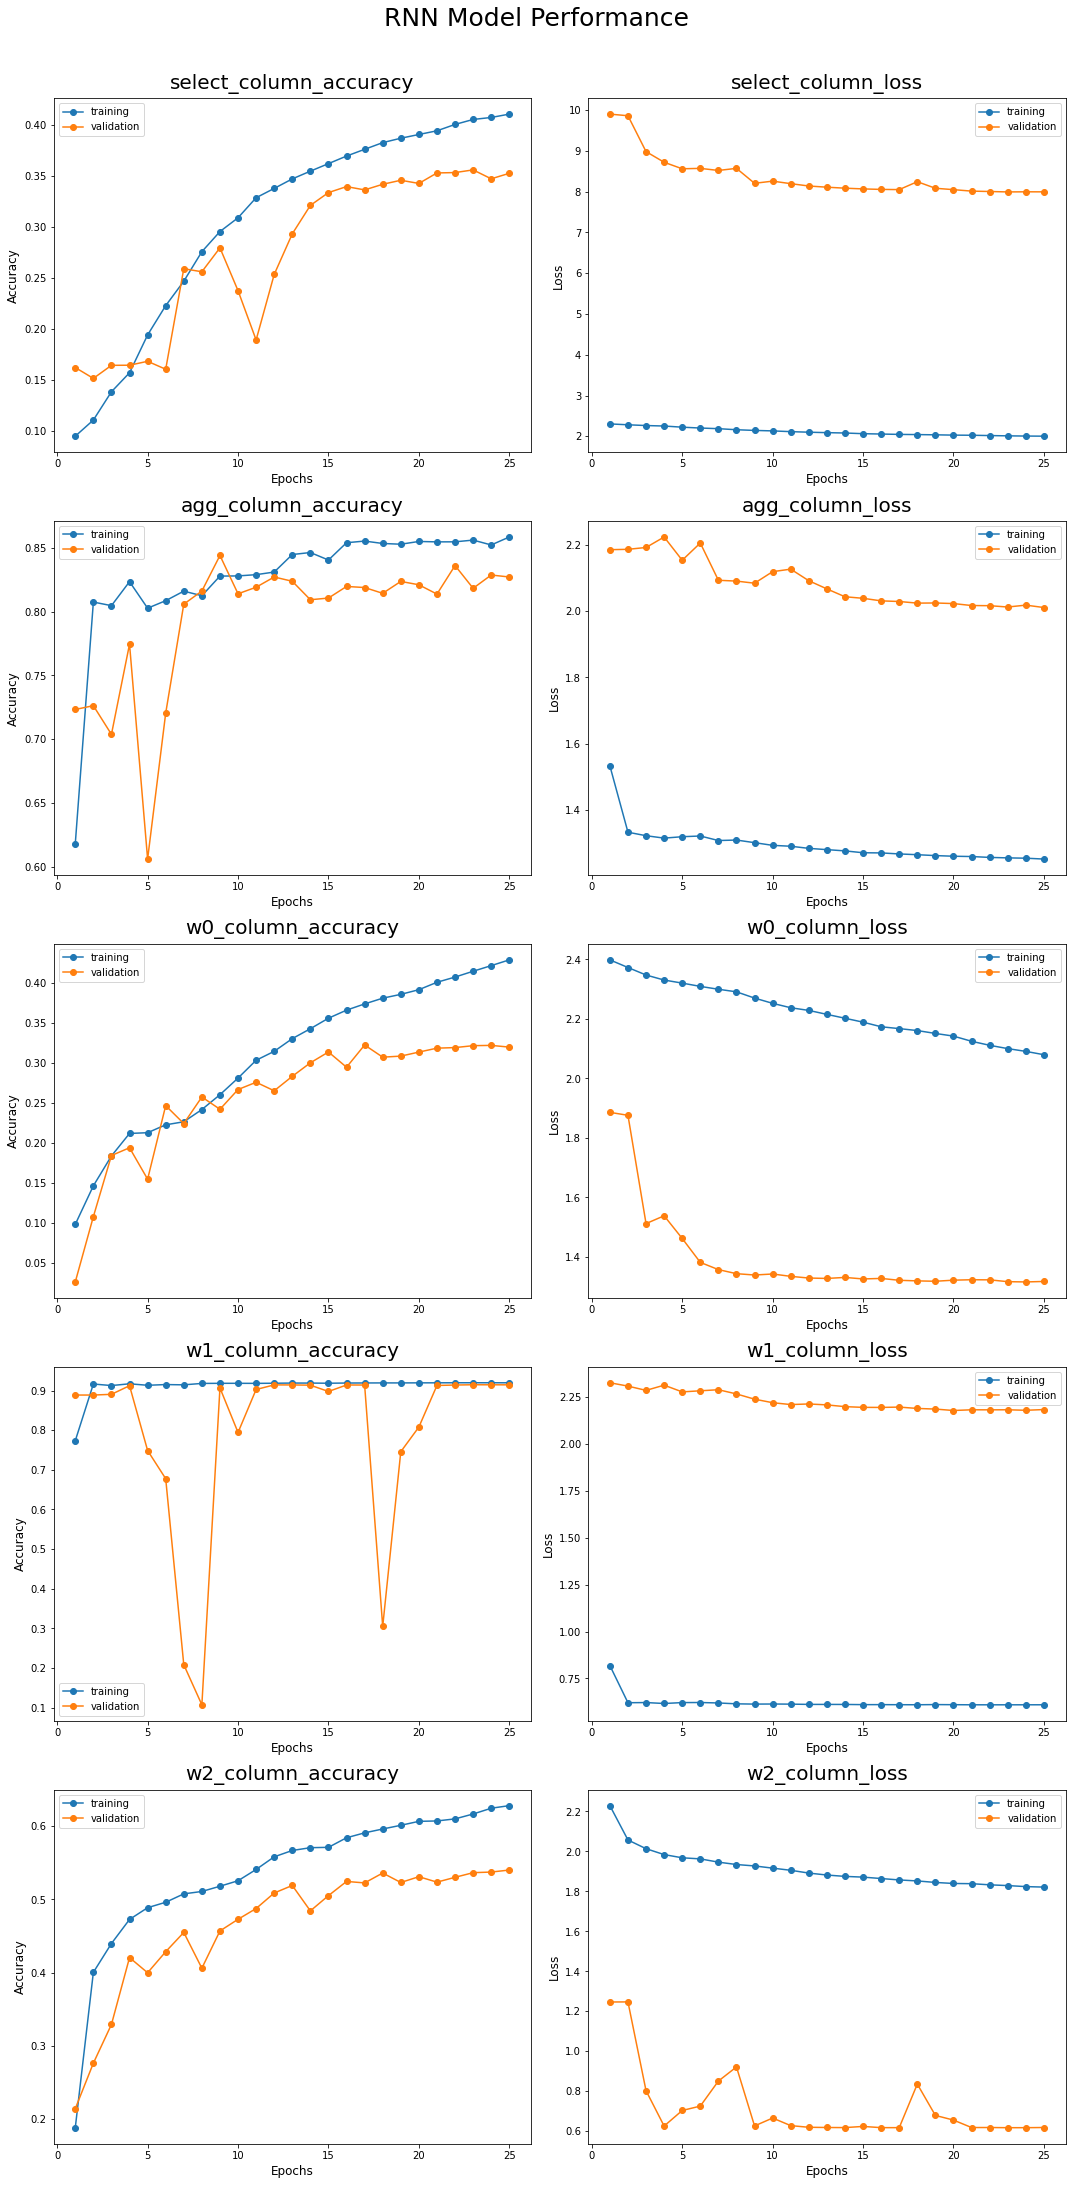

In [25]:
# Create the figure and the axes array 
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 30))

# For loop for the five outputs
for i in range(5):
    # For loop for loss or accuracy plot
    for j in range(2):
        # Plot loss Vs. epoch on first figure column
        if j == 0:
            epochs = range(1,len(history.history['loss'])+1)
            train = list(history.history.keys())[i+6]
            val = list(history.history.keys())[i+17]
            ax[i, j].plot(epochs, history.history[train], label="training", marker="o")
            ax[i, j].plot(epochs, history.history[val], label="validation", marker="o")
            ax[i, j].set_title(train,size = 20,y=1.01)
            ax[i, j].set_xlabel("Epochs", size = 12)
            ax[i, j].set_ylabel("Accuracy", size = 12)
            ax[i, j].legend()
        # Plot accuracy Vs. epoch on second figure column
        if j == 1:
            epochs = range(1,len(history.history['loss'])+1)
            train = list(history.history.keys())[i+1]
            val = list(history.history.keys())[i+11]
            ax[i, j].plot(epochs, history.history[train], label="training", marker="o")
            ax[i, j].plot(epochs, history.history[val], label="validation", marker="o")
            ax[i, j].set_title(train,size = 20, y=1.01)
            ax[i, j].set_xlabel("Epochs", size = 12)
            ax[i, j].set_ylabel("Loss", size = 12)
            ax[i, j].legend()

fig.suptitle("RNN Model Performance", size = 25, y=1.01)
fig.tight_layout()

The model ran for the whole 25 epochs.

Looking at the plots above we can see that in all the outputs the `train` accuracy curve is always above the `validation` accuracy curve and both have a growing trend.

The model is overfitting in all the outputs after the first few epochs because the `train` and `validation` curves are moving apart from each other.

Loss functions are not dropping (stay constant) and this is another indicator that the model is overfitting after the first few epochs.

The `train` loss curve should always be below the `validation` loss curve but in some cases it's above (first_where_column and third_where_column).

It's also interesting to notice again that the validation accuracy of second_where_column (`w1_column_accuracy`) drops consistently at epoch 9 and also at epoch 18 and then goes back up to where it was before. This is not happening on the train set, and there is no sign of changing in the loss function. This is quite unexpected and might be related to the learning rate.

## Results

Let's make the predictions on the `test`set and check the model accuracies on it.

In [26]:
test_pred = RNN_model.predict(X_test_tok)

In [27]:
test_pred_sel = np.argmax(test_pred[0], axis=1) 
test_pred_agg = np.argmax(test_pred[1], axis=1) 
test_pred_w0 = np.argmax(test_pred[2], axis=1) 
test_pred_w1 = np.argmax(test_pred[3], axis=1) 
test_pred_w2 = np.argmax(test_pred[4], axis=1) 

In [28]:
print(f"Test Accuracy Select column: {accuracy_score(y_test['select_col'], test_pred_sel)}")
print(f"Test Accuracy Agg column: {accuracy_score(y_test['agg_col'], test_pred_agg)}")
print(f"Test Accuracy first where column: {accuracy_score(y_test['first_where_col_0'], test_pred_w0)}")
print(f"Test Accuracy second where column: {accuracy_score(y_test['first_where_col_1'], test_pred_w1)}")
print(f"Test Accuracy third where column: {accuracy_score(y_test['first_where_col_2'], test_pred_w2)}")

Test Accuracy Select column: 0.34012827840223536
Test Accuracy Agg column: 0.8331110687750047
Test Accuracy first where column: 0.3121864482123579
Test Accuracy second where column: 0.9172540801422493
Test Accuracy third where column: 0.5368641646027815


The accuracy results are a bit lower than the previous model (unweighted model)

The accuracy on the Agg column and second where column are quite good (83% and 91%) because the model had fewer classes to chose from, 5 and 3 respectively.

All the other outputs, where the classes are 10 to 11, have lower accuracies (34%, 31% and 54%).

Let's have a look at the confusion matrix of each output.

In [29]:
# Make the list of the five predictions
test_pred_list = [test_pred_sel, test_pred_agg, test_pred_w0, test_pred_w1, test_pred_w2]
# Create an empty dictionary
conf_mat_dict = {}

# Create a confusion matrix for each output
for i in range(len(test_pred_list)): 
    conf_mat = confusion_matrix(y_test.iloc[:, i], test_pred_list[i])
    # Append the matrix to the dictionary
    conf_mat_dict[i] = conf_mat

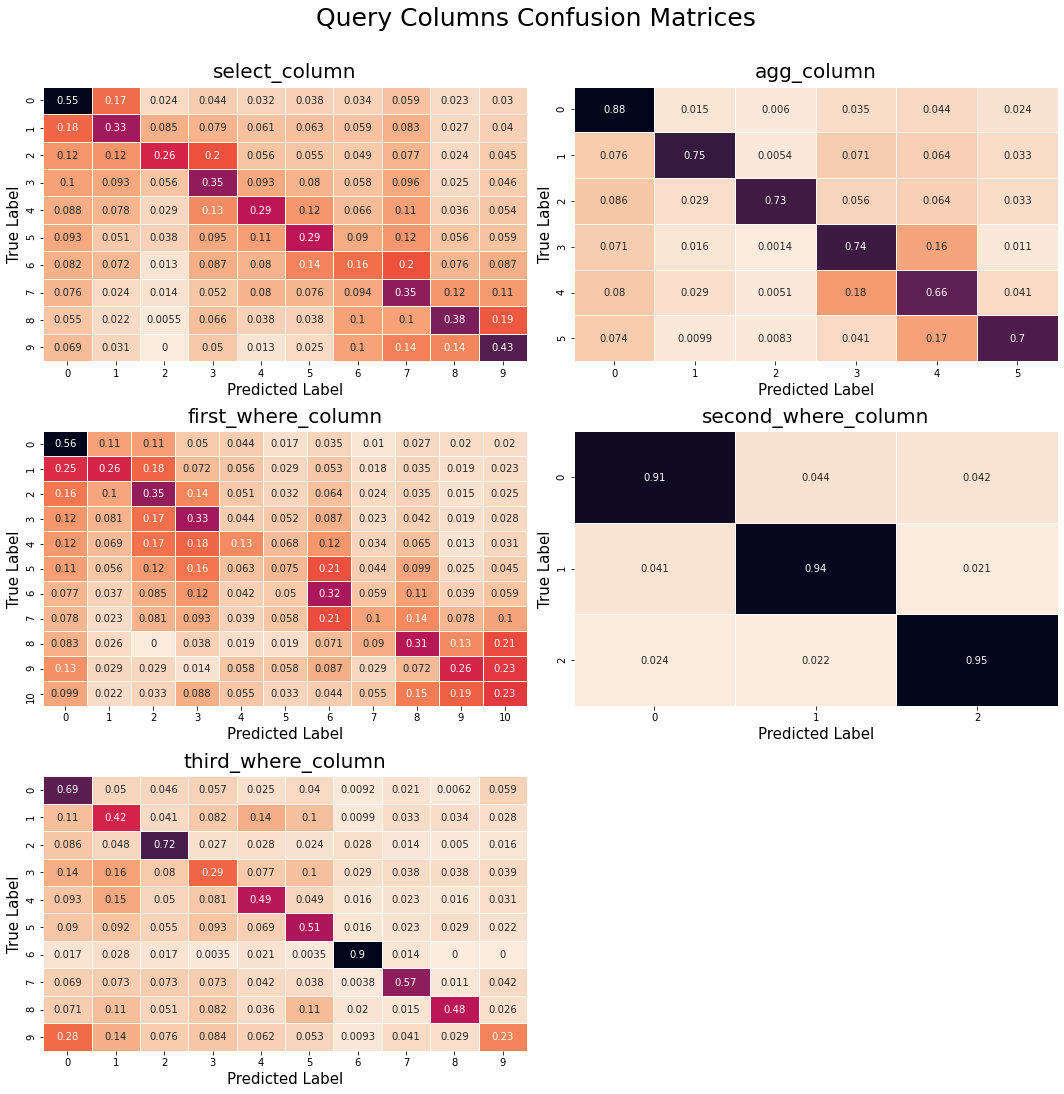

In [30]:
# Create the list of column names
columns = ['select_column', 'agg_column', 'first_where_column', 'second_where_column', 'third_where_column']
# Create the figure and the axes array 
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
# Flatten the axes from a 3x2 to a 6x1
ax = ax.flatten()

# Plot the confusion matrices
for i in range(5):
    conf_mat = conf_mat_dict[i]
    # Normalize the confusion matrix along the 'predicted' columns
    normalized_conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
    sns.heatmap(normalized_conf_mat,
                        annot=True,
                        cbar=False,
                        cmap="rocket_r",
                        linewidths=1, ax=ax[i]
                       )
    # Set the title, x and y labels
    ax[i].set_title(columns[i], size = 20,y=1.01)
    ax[i].set_xlabel("Predicted Label", size = 15)
    ax[i].set_ylabel("True Label", size = 15)

# Plot the title of the figure
fig.suptitle("Query Columns Confusion Matrices", size = 25, y=1.01)
fig.tight_layout()

# Delete the last subplot
fig.delaxes(ax[-1])

The class weights changed the results of the confusion matrices.

We were definitely able to improve the true predictions (values along the diagonals). The model is now predicting all the classes and it's doing a better job than the base model. There are still miss-predictions in output with a lot of classes but the model is actually doing a decent job on the outputs with fewer classes (agg_column and second_where_column).

Let's save the model.

In [31]:
RNN_model.save("s2sql")

INFO:tensorflow:Assets written to: s2sql/assets


This is the end of Jupyter Notebook 5 of 6. In the next one we'll compare the results of the three models and we'll try to draw some conclusions in order to understand the path forward for the problem